<a href="https://colab.research.google.com/github/EladAssia/Bats-EEG/blob/master/Bats_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Connect to drive**

---


Connect to the drive to import the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import libraries**

---


Import necessary libraries for importing data, plotting and model creation

In [2]:
import os
import scipy.io
from scipy.signal import spectrogram
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Model
from keras.layers import Input, Activation, Dropout, BatchNormalization
from keras.layers import Dense, LSTM, Conv1D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import backend as K
%matplotlib inline 

Using TensorFlow backend.


**Parameters and settings**


---


Set the parameters and settings

In [0]:
seed = 0 # do not change
classes = ['ASI', 'ASM', 'AWI', 'AWM'] # classes
num_of_conds = len(classes) # number of classes
split_raw = False # whether to split each 10-sec segment to teb 1-sec segments
leave_bat = False # whether to leave the last bat as test
save_data = False # whether to save the data to the drive
s_rate = 500 # the sample rate
data_process = 'Wavelets' # switch between 'ERP' and 'Wavelets' data
dev_per = 0.1 # percentage of the dev data
drop_rate = 0.8 # the dropout value
batch_size = 32 # the batch size
epochs = 50 # number of epochs
folds = 5 # number of k-folds for cross-validation
model_type = 'wav' # set the model type. Can choose between 'EEG_LSTM', 'EEGNet', 'DeepConvNet' and 'EEGNet_SSVEP'
base_folder = 'drive/My Drive/Colab Notebooks/Bats EEG' # set the base folder
data_folder = base_folder + '/Data/' # set the data folder
checkpoint_path = base_folder + "/Models/checkpoints/" + data_process + "_cp.ckpt" # set the checkpoint name
checkpoint_dir = os.path.dirname(checkpoint_path) # set the checkpoint folder

**Import data**

---


Import the bats data and labels

In [4]:
x = [] # set the data as empty
y = [] # set the labels as empty
files = os.listdir(data_folder) # read the files in the folder
for file in files: # run over the files
  if file[-3:] == 'mat': # if the file is a mat file
    f = scipy.io.loadmat(data_folder + file) # read the file
    for k in list(f.keys()): # run over the keys in the file
      if 'eeg' in k or 'EEG' in k: # if this is an eeg data
        ex = pd.read_excel(data_folder + file[:-3] + 'xlsx', header=None) # read the excel file
        j = 0
        for i in range(len(ex)): # run over each row in the excel file
          tmp = f[k][int(ex[0][i]*s_rate):int(ex[1][i]*s_rate), 0] # take the relevant data
          if np.sum(np.isnan(tmp)) == 0: # check that there are no NaNs
            j += 1
            if split_raw: # split the segment to 10 segments of one-sec
              for j in range(0, tmp.shape[0], s_rate):
                x.append(tmp[j:j+s_rate]) # append the row
                y.append(ex[2][i]-1) # append the label
            else:
              x.append(tmp) # append the row
              y.append(ex[2][i]-1) # append the label

x = np.array(x) # transform the data list to data array
y = np.array(y) # transform the label list to label array
print('Total data size is: {} and label size is: {}'.format(x.shape, y.shape))


if leave_bat:
  x_test = x[-j:, :]
  Y_test = y[-j:]
  x = x[:-j, :]
  y = y[:-j]
  print('Train data size is: {} and label size is: {}'.format(x.shape, y.shape))
  print('Test data size is: {} and label size is: {}'.format(x_test.shape, Y_test.shape))
  x_test = (x_test- np.max(np.max(x_test)))/(np.max(np.max(x_test)) - np.min(np.min(x_test)))

x = (x- np.max(np.max(x)))/(np.max(np.max(x)) - np.min(np.min(x)))

Total data size is: (1306, 5000) and label size is: (1306,)


Plot data histogram function

In [0]:
def plot_hist(data, names, ttl):
  # This function plots a histogram of the classes frequencies
  
  # Inputs:
  # data - the set labels
  # names - the classes' names
  # ttl - the title of the histogram
  
  n = plt.hist(data, bins = len(names), rwidth=0.5) # plot the histogram
#   print(n) # print the number of each class frequency
  plt.xticks(np.arange(0.38, len(names)-1, 0.75), names) # change the bins' names to the classes
  plt.xlabel('Classes') # add x axis label
  plt.ylabel('Frequency') # add y axis label
  plt.title(ttl) # add title
  plt.show() # show image

Plot the histogram of the data

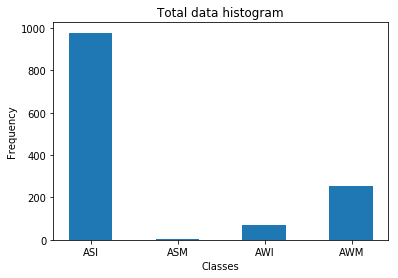

In [6]:
if leave_bat:
  plot_hist(y, classes, 'Train data histogram')
  plot_hist(Y_test, classes, 'Test data histogram')
else:
  plot_hist(y, classes, 'Total data histogram')

**Data process**

---


A function that converts the ERP to Wavelets

In [0]:
def convert_to_wavelets(data, fs):
#   print(data.shape)
#   return
  fs = fs # Sampling frequencies
  nfft = fs # Length of each window segment
  nperseg = 64 # Number of points per segment
  noverlap = nperseg-1 # Overlap between windows
  first_seg = True
  
  for i in range(data.shape[0]):
    f, t, x = spectrogram(data[i], fs=fs, nperseg = nperseg, nfft=nfft, noverlap=noverlap)
    f = np.where(f>64)[0][0]
    x = x[:f, :]
    if first_seg:
      first_seg = False
      new_data = np.empty((data.shape[0], x.shape[0], x.shape[1]))
    new_data[i] = x
    
  return new_data

Check if to transform to wavelets

In [8]:
if data_process == 'Wavelets': # if the data process is wavelets
  X = convert_to_wavelets(x, s_rate) # convert the ERPs trials to wavelets
  del x
  if leave_bat:
    X_test = convert_to_wavelets(x_test, s_rate)
    del x_test
    print('Train data size is: {}'.format(X.shape))
    print('Test data size is: {}'.format(X_test.shape))
  else:
    print('Data size is: {}'.format(X.shape))

Data size is: (1306, 65, 4937)


In [0]:
if save_data:
  np.save(data_folder + 'data', X)
  np.save(data_folder + 'labels', y)
  if leave_bat:
    np.save(data_folder + 'test_data', X_test)
    np.save(data_folder + 'test_labels', y_test)


Divide the data to train and test

Number of train data: 1175, number of train labels: 1175
Number of validation data: 131, number of validation labels: 131


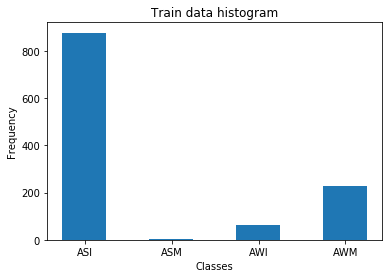

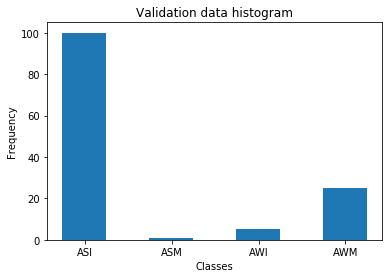

In [10]:
if not leave_bat:
  X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=dev_per, random_state=4)
  print('Number of train data: {}, number of train labels: {}'.format(X_train.shape[0], Y_train.shape[0]))
  print('Number of validation data: {}, number of validation labels: {}'.format(X_test.shape[0], Y_test.shape[0]))
  plot_hist(Y_train, classes, 'Train data histogram')
  plot_hist(Y_test, classes, 'Validation data histogram')
else:
  X_train, Y_train = X, y
  
del X

Y_train = to_categorical(Y_train) # change to one-hot vector
Y_test = to_categorical(Y_test) # change to one-hot vector

**Models**

---

ERP model

In [0]:
def ERP_model(input_shape, nb_classes = 1, dropoutRate = 0.5):
  
  input1 = Input(shape = input_shape)
  
  x = LSTM(units = 128, return_sequences=False)(input1)
  x = Activation('relu')(x)
  x = Dropout(dropoutRate)(x)
  x = BatchNormalization()(x)
  
  x = Dense(units = nb_classes)(x)
  softmax = Activation('softmax', name = 'softmax')(x)
  
  return Model(inputs=input1, outputs=softmax)

Wavelets model

In [0]:
def Wav_model(input_shape, nb_classes = 1, dropoutRate = 0.5):
  
  input1 = Input(shape = input_shape)
  x = Conv1D(196, kernel_size=15, strides=4)(input1)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(dropoutRate)(x)
  
  x = LSTM(units = 128, return_sequences=True)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(dropoutRate)(x)
  
  x = LSTM(units = 128, return_sequences=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(dropoutRate)(x)
  
  x = Dense(units = nb_classes)(x)
  out = Activation('softmax', name = 'softmax')(x)
  
  return Model(inputs=input1, outputs=out)

Create the model and call the function for creating the model, the optimizer and the loss function

In [13]:
while model_type.lower() != 'erp' and model_type.lower() != 'wav':
  model_type = input('Please enter the model type. You may choose between "ERP" to "Wav"')
  
if model_type.lower() == 'erp':
  model = ERP_model(input_shape = (X_train.shape[1], X_train.shape[2]), 
                   nb_classes = num_of_conds, dropoutRate = drop_rate)
elif model_type.lower() == 'wav':
  model = Wav_model(input_shape = (X_train.shape[1], X_train.shape[2]), 
                   nb_classes = num_of_conds, dropoutRate = drop_rate)

model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

cp_callback = ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)

W0626 11:26:53.316232 139959226587008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0626 11:26:53.341419 139959226587008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0626 11:26:53.347875 139959226587008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0626 11:26:53.463209 139959226587008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0626 11:26:53.496681 

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 65, 4937)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13, 196)           14514976  
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 196)           784       
_________________________________________________________________
activation_1 (Activation)    (None, 13, 196)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 196)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 13, 128)           166400    
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 128)           512       
__________

In [15]:
data_size = X_train.shape[0]
folds_ = [i for i in range(0, X_train.shape[0], int(math.ceil(X_train.shape[0]/folds)))]
folds_.append(data_size)
history = []
idx = np.arange(data_size)
for i in range(len(folds_)-1):
  print('Starting fold number: {}/{}'.format(i+1, folds))
  train_idx = np.delete(idx, np.arange(folds_[i], folds_[i+1]))
  x_train, y_train = X_train[train_idx], Y_train[train_idx] 
  x_val, y_val = X_train[folds_[i]:folds_[i+1]], Y_train[folds_[i]:folds_[i+1]]
  tmp = model.fit(x_train, y_train, 
              batch_size = batch_size, 
              epochs = epochs, 
              validation_data = (x_val, y_val),
#               callbacks = [cp_callback])
                 )
  history.append(tmp)
  del tmp
  

Starting fold number: 1/5


W0626 11:26:55.615324 139959226587008 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 940 samples, validate on 235 samples
Epoch 1/50
940/940 [==============================] - 11s 11ms/step - loss: 1.3809 - acc: 0.5415 - val_loss: 1.2084 - val_acc: 0.8170
Epoch 2/50
940/940 [==============================] - 6s 7ms/step - loss: 0.8569 - acc: 0.7628 - val_loss: 1.2675 - val_acc: 0.8340
Epoch 3/50
940/940 [==============================] - 6s 7ms/step - loss: 0.8337 - acc: 0.8043 - val_loss: 1.1316 - val_acc: 0.8340
Epoch 4/50
940/940 [==============================] - 7s 7ms/step - loss: 0.7429 - acc: 0.8202 - val_loss: 1.2577 - val_acc: 0.8340
Epoch 5/50
940/940 [==============================] - 7s 7ms/step - loss: 0.6997 - acc: 0.8383 - val_loss: 1.1044 - val_acc: 0.8383
Epoch 6/50
940/940 [==============================] - 7s 7ms/step - loss: 0.7257 - acc: 0.8191 - val_loss: 1.0703 - val_acc: 0.8426
Epoch 7/50
940/940 [==============================] - 7s 7ms/step - loss: 0.5730 - acc: 0.8564 - val_loss: 0.9188 - val_acc: 0.8511
Epoch 8/50
940/940 [========

In [0]:
for i in range(1, len(history)):
  for k in list(history[0].history.keys()):
    history[0].history[k].extend(history[i].history[k])
history = history[0]

In [17]:
y_pred = model.predict(X_test, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

131/131 [==============================] - 1s 7ms/step


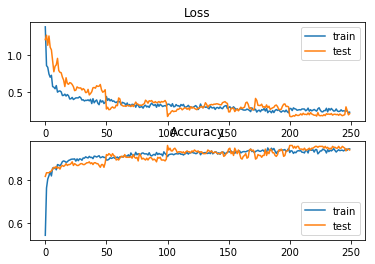

In [18]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

Precision, recall and F1 

In [19]:
print(classification_report(np.argmax(Y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       100
           1       0.00      0.00      0.00         1
           2       0.50      0.20      0.29         5
           3       0.96      0.96      0.96        25

    accuracy                           0.95       131
   macro avg       0.60      0.54      0.55       131
weighted avg       0.93      0.95      0.94       131



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Plot Confusion matrix function

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
  
  # This function plots the confusion matrix of the classes
  
  # Inputs:
  # y_test - the real labels
  # y_pred - the predicted labels
  # classes - the classes names
  
  cm = confusion_matrix(y_true, y_pred) # compute confusion matrix
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the confusion matrix

  fig = plt.subplot() # set figure
  plt.imshow(cm, interpolation='nearest', cmap=cmap) # plot the confusion matrix
  
  plt.colorbar()
  plt.xticks(range(len(classes)), classes) # add ticks labels
  plt.yticks(range(len(classes)), classes) # add ticks labels
  plt.xlabel('Predicted') # add x label
  plt.ylabel('True') # add y label


  # Loop over data dimensions and create text annotations.
  fmt = '.2f'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          fig.text(j, i, format(cm[i, j], fmt),
                  ha="center", va="center",
                  color="white" if cm[i, j] > thresh else "black")
  plt.show()

Plot confusion matrix

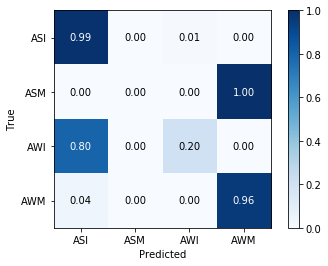

In [21]:
plot_confusion_matrix(np.argmax(Y_test, axis=1), y_pred, classes)